In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import HTC
import time


In [3]:
# Load connectome and normalize it

W=np.loadtxt("../Data/connectivity_matrix/weights.txt")
#W=np.loadtxt("../Data/Hagmann/group_mean_connectivity_matrix_file.txt")
W=W/W.sum(axis=1)[:,None]

In [4]:
# Create brain object and set its parameters

brain=HTC.Brain(W)
#brain.set_netowrk_parameters(2/998,(2/998)**(1/5),(2/998)**(1/5)/(1+2*(2/998)**(1/5))/1.2)
n_neurons=brain.n_neurons
brain.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2, tc=0.12)

In [10]:
# Generate initial configuration with 10% active neurons

states_orig = HTC.generate_initial_conf(active_frac=0.1, n_neurons=brain.n_neurons, n_runs=50) # with random configurations


# Evolve over time the states (save every step in activity matrix)

n_timesteps=600
n_runs=50
activity=np.zeros((n_timesteps,n_runs, brain.n_neurons)) #storing time, run and activity
states=states_orig

for t in range(n_timesteps):
    states, activity[t] = HTC.update_states(states=states,
                                            r1=brain.r1,r2= brain.r2,tc= 0.15,W= W)

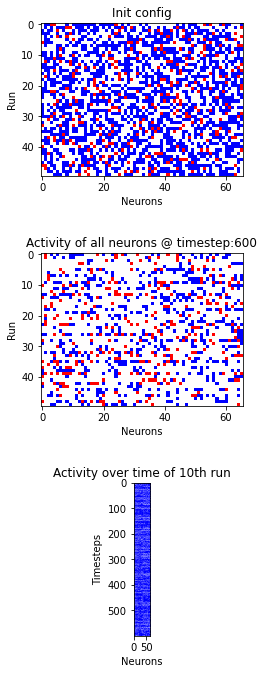

In [11]:
    
fig,ax=plt.subplots(3,1, figsize=(15,10))

ax[0].set_xlabel("Neurons")
ax[0].set_ylabel("Run")
ax[0].set_title("Init config")
ax[0].imshow(states_orig, cmap='bwr')

ax[1].set_xlabel("Neurons")
ax[1].set_ylabel("Run")
ax[1].set_title("Activity of all neurons @ timestep:"+str(n_timesteps)+"")
ax[1].imshow(states, cmap='bwr')

run=10
ax[2].set_title("Activity over time of "+str(run)+"th run")
ax[2].set_ylabel("Timesteps")
ax[2].set_xlabel("Neurons")
ax[2].imshow(activity[:,run], cmap='bwr')

fig.tight_layout(pad=3.0)

plt.show()

In [34]:
a1=6
a2=12
b=0.9
c=0.35
d1=a1*b
d2=a2*b

x=np.linspace(0,25, 250)
t=np.linspace(0,60, 600)

y=((x/d1)**a1)*np.exp(-(x-d1)/b)-c*((x/d2)**a2)*np.exp(-(x-d2)/b)


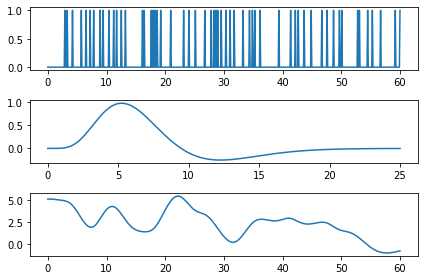

In [46]:
fig,ax=plt.subplots(3,1)
ax[0].plot(t,activity[:,1,1])

ax[1].plot(x,y)
ax[2].plot(t,np.convolve(activity[:,1,1],y, mode='same'))

fig.tight_layout()

plt.show()

In [9]:
active_frac=0.1
n_runs=50
tmin=0.01
tmax=0.3
delta_tc=0.01
dt=0.1
n_timesteps=600
s_step=10
compute_s1_s2=True
compute_s_distrib=True

In [6]:
%%time
tc, a,sigma_a,s1,s2,s_distrib=brain.simulation(active_frac=active_frac, n_runs=n_runs,
                      tmin=tmin, tmax=tmax, delta_tc=delta_tc,
                      dt=dt, n_timesteps=n_timesteps,
                      compute_s1_s2=compute_s1_s2, s_step=s_step,
                      compute_s_distrib=compute_s_distrib, tc_distrib=0.15)

CPU times: user 16.3 s, sys: 677 ms, total: 17 s
Wall time: 13.6 s


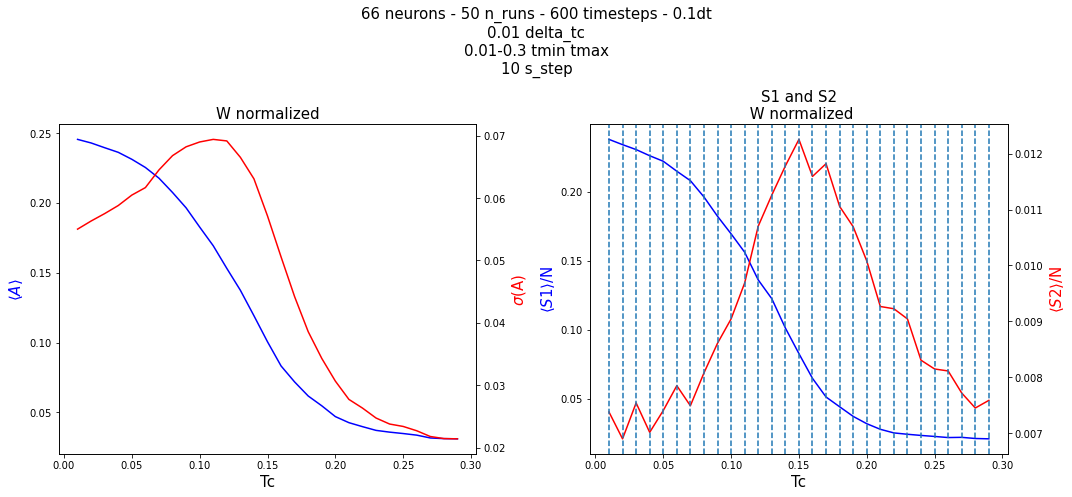

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,7))

ax01=ax0.twinx()

ax0.set_title("W normalized", size=15)
ax0.set_xlabel("Tc", size=15)
ax0.set_ylabel(r"$\langle A \rangle$", size=15)
ax0.plot(tc, a, color="blue")
ax0.yaxis.label.set_color("blue")
#ax0.plot(tc, a-s1/brain.n_neurons)


ax01.set_ylabel(r'$\sigma$(A)', size=15)
ax01.plot(tc, sigma_a, "red")
ax01.yaxis.label.set_color("red")

ax1.set_title("S1 and S2\n W normalized", size=15)
ax1.set_xlabel("Tc", size=15)
ax1.set_ylabel(r"$\langle S1 \rangle$/N", size=15)
ax1.plot(tc, s1/brain.n_neurons, color="blue")
ax1.yaxis.label.set_color("blue")


ax11=ax1.twinx()
ax11.plot(tc,s2/brain.n_neurons, color="red")
ax11.set_ylabel(r"$\langle S2 \rangle$/N", size=15)
ax11.yaxis.label.set_color("red")
for i in tc:
    ax11.axvline(x=i, ls="--")

fig.suptitle(str(n_neurons)+" neurons - "+str(n_runs)+" n_runs - "
             +str(n_timesteps)+" timesteps - "+str(dt)+"dt\n"
             +str(delta_tc)+" delta_tc\n"+str(tmin)+"-"
             +str(tmax)+" tmin tmax\n"+str(s_step)
             +" s_step", size=15)
plt.tight_layout()


plt.savefig("../Output/"+str(n_neurons)+"_neurons_"+
            str(n_runs)+"_nruns_"+str(n_timesteps)+
            "_timesteps"+time.strftime('%m%d%y_%H%M', time.localtime())+".jpg")
plt.show()

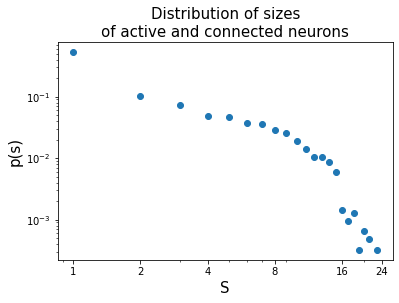

In [8]:
import matplotlib.ticker

x,ll=HTC.get_sizes_distribution(s_distrib)

fig, ax=plt.subplots()
ax.scatter(x,ll )
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("S", size=15)
ax.set_ylabel("p(s)", size=15)
ax.set_xticks([1,2,4,8,16,24])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_title("Distribution of sizes\nof active and connected neurons", size=15)

plt.savefig("../Output/"+str(n_neurons)+"_neurons_"+
            str(n_runs)+"_nruns_"+str(n_timesteps)+
            "_timesteps"+time.strftime('%m%d%y_%H%M', time.localtime())+"_sizes_distribution.jpg")

plt.show()